In [67]:
#from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
from collections import deque
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from operator import itemgetter 

In [90]:
mypath = 'eric_jh_data/'
countries = sorted(['Australia', 'Japan', 'China'])
fx_dict = {'Australia':('eric_jh_data/Forex/AUD_USD_new.csv',0),
           'Japan':('eric_jh_data/Forex/USD_JPY_new.csv',1),
           'China':('eric_jh_data/Forex/USD_HKD_new.csv',1)}

list_pairs = []
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f)) and f != ".ipynb_checkpoints"] #grab all adr names of the country
    for adr in sorted(adr_names):
        list_pairs.append((country, adr))

In [91]:
def data_processing(country, adr, fx_dict, forex_bps = 10, adjust_forex_expense = True):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    ratio_path = f'eric_jh_data/{country}/{adr}/ratio.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open', 'volume' : 'adr_volume'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open', 'volume' : 'stock_volume'})
    fx_df = pd.read_csv(fx_path, index_col = 0)
    ratio_df = pd.read_csv(ratio_path, index_col = 0)

    # Invert fx data so that all prices are reflected in USD
    if fx_type == 0:
        inverted_fx_df = 1/fx_df.iloc[:,[2,1,4,3,6,5,8,7]].copy()
        inverted_fx_df.columns = fx_df.columns[1:]
        fx_df.iloc[:,1:] = inverted_fx_df
    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close', 'adr_volume']], stock_df.loc[:,['date', 'stock_open','stock_close', 'stock_volume']])
    merged_df = pd.merge(merged_df, fx_df)
    ratio_geq_1, ratio = ratio_df["ratio_geq_1"].item(), ratio_df["ratio"].item()

#     ratio is (stock price in USD)/(ADR price)
#     If ratio >= 1, we shall buy 1 stock, and sell multiple adrs
#     If ratio < 1, we shall sell 1 adr, and buy multiple stocks
    if ratio_geq_1:
        merged_df["stock_num_per_unit"] = 1
        merged_df["adr_num_per_unit"] = ratio
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]*ratio
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]*ratio
    else:
        merged_df["stock_num_per_unit"] = ratio
        merged_df["adr_num_per_unit"] = 1
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]*ratio
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]*ratio
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]    
    
    if adjust_forex_expense:
        # Added expense for trading small amounts in forex market
        forex_bid_multiplier = 1 - 0.0001*forex_bps
        forex_ask_multiplier = 1 + 0.0001*forex_bps
        merged_df.loc[:,merged_df.columns.str.contains("bid")] *= forex_bid_multiplier
        merged_df.loc[:,merged_df.columns.str.contains("ask")] *= forex_ask_multiplier
        
    return merged_df

In [92]:
def calc_max_drawdown(portfolio_values, method = "percentage"):
    peak, trough = portfolio_values[0], portfolio_values[0]
    max_drawdown = 0
    for i in range(1, len(portfolio_values)):
        if portfolio_values[i] < trough:
            trough = portfolio_values[i]
            if method == "percentage":
                max_drawdown = max(max_drawdown, (peak - trough)/peak)
            else:
                max_drawdown = max(max_drawdown, peak - trough)
        elif portfolio_values[i] > peak:
            peak, trough = portfolio_values[i], portfolio_values[i]
    return max_drawdown

In [93]:
def get_risk_statistics(stock_values, adr_values, var_ci):
    port_stock = stock_values - adr_values
    port = pd.DataFrame(data = port_stock)
    port_diff = port - port.shift(1)
    pnl = pd.DataFrame(port_diff).dropna()
    sigma = pnl.std()[0]
    pnl['pct_rank'] = pnl.rank(pct=True)
    pnl.columns =['daily_pl', 'pct_rank']
    var = abs(pnl[pnl.pct_rank< 1-var_ci].daily_pl.max())
    max_drawdown_abs = calc_max_drawdown(port_stock, "absolute")
    return sigma, var, max_drawdown_abs

In [94]:
def plot_returns(dates, portfolio_values, num_xticks = 5):
    plt.plot(portfolio_values)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)// num_xticks)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), rotation = 45)
    plt.show();

In [95]:
list_pairs_copy = list_pairs.copy()
list_pairs_aus = list_pairs[:9]
list_pairs_chi = list_pairs[9:18]
list_pairs_jap = list_pairs[18:]
# list_pairs = list_pairs_aus
# list_pairs = list_pairs_chi
list_pairs = list_pairs_jap
#list_pairs = list_pairs_copy

# Global Variant 1

In [96]:
df_dict = {}
for (country, adr) in list_pairs:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    ind_hp_dict = {}
    # Should be read in from file
    ind_hp_dict["lookback"] = 100
    ind_hp_dict["entry"] = 1
    ind_hp_dict["exit"] = 1
    ind_hp_dict["stop_loss"] = 3
    ind_hp_dict["allocation"] = 1/len(list_pairs)
    hp_dict[(country, adr)] = ind_hp_dict
    
diff_record_bid_dict = {}
diff_record_ask_dict = {}
for (country, adr) in list_pairs:
    diff_record_bid_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_ask_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 1000000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [97]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = prev_cash
        print(current_date)
        print(f"Cash:{prev_value}")
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                print(f"{country}:{adr}")
                
                # Add adr values
                prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                print(f"Add {adr}:{prev_value}")
                # Add stock values
                prev_value += positions[(country, adr)]["stock_pos"]*(row['stock_open']/row['avg_ask_non_us_at'])
                print(f"Add Stock:{prev_value}")
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
            
            # Short borrowing interest
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
        prev_cash = cash
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record_bid = diff_record_bid_dict[(country, adr)]
                    diff_record_ask = diff_record_ask_dict[(country, adr)]
                    diff_record_bid.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
                    diff_record_ask.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])

                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    if len(diff_record_bid) < lookback or row["date"] < start_date or merged_df.loc[index+1, "date"] > end_date:
                        continue

                    ask_mean = np.array(diff_record_ask).mean()
                    bid_std = np.array(diff_record_bid).std()
                    ask_std = np.array(diff_record_ask).std()

                    entry = hp_dict[(country, adr)]["entry"]
                    exit = hp_dict[(country, adr)]["exit"]
                    stop_loss = hp_dict[(country, adr)]["stop_loss"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]

                    if diff_record_bid[-1] > ask_mean + entry*bid_std and diff_record_bid[-1] <= ask_mean + stop_loss*bid_std:
                        if stock_pos == 0 and adr_pos == 0:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    continue
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   

                            stock_pos += stock_quantity
                            positions[(country, adr)]["stock_pos"] += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash -= stock_px*stock_quantity
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                            prev_cash = cash
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_pos -= adr_quantity
                            positions[(country, adr)]["adr_pos"] -= adr_quantity
                            adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            positions[(country, adr)]["holding_period"] = 0
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {round(stock_px,2)} USD (Total: {round(stock_quantity*stock_px,2)}, {round(stock_px_fx,2)} foreign dollars) on {row['date']}\n")
                            trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {round(adr_px,2)} (Total: {round(adr_quantity*adr_px,2)}) on {merged_df.loc[index+1,'date']}\n")

                    # Liquidation condition
                    elif (diff_record_ask[-1] < ask_mean + exit*ask_std or 
                          diff_record_bid[-1] > ask_mean + stop_loss*bid_std or 
                          holding_period == maximum_holding_period):
                        if stock_pos > 0 and adr_pos < 0 : 
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                            cash += stock_pos*stock_px
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                            prev_cash = cash
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {round(stock_px,2)} USD (Total: {round(stock_quantity*stock_px)}{round(stock_px_fx,2)} foreign dollars) on {row['date']}\n")
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {round(adr_px,2)} (Total: {round(-adr_pos*adr_px,2)}) on {merged_df.loc[index+1,'date']}\n")

                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None

                #iter_dict[(country, adr)]["has_current_date"] = False

2016-01-04
Cash:1000000
Japan:CAJ_7751
Add CAJ_7751:1000000.0
Add Stock:1000000.0
Japan:TM_7203
Add TM_7203:1000000.0
Add Stock:1000000.0
2016-01-05
Cash:1000000
Japan:CAJ_7751
Add CAJ_7751:1000000.0
Add Stock:1000000.0
Japan:TM_7203
Add TM_7203:1000000.0
Add Stock:1000000.0
2016-01-06
Cash:1000000
Japan:CAJ_7751
Add CAJ_7751:1000000.0
Add Stock:1000000.0
Japan:TM_7203
Add TM_7203:1000000.0
Add Stock:1000000.0
2016-01-07
Cash:1000000
Japan:CAJ_7751
Add CAJ_7751:1000000.0
Add Stock:1000000.0
Japan:TM_7203
Add TM_7203:1000000.0
Add Stock:1000000.0
2016-01-08
Cash:1000000
Japan:CAJ_7751
Add CAJ_7751:1000000.0
Add Stock:1000000.0
Japan:TM_7203
Add TM_7203:1000000.0
Add Stock:1000000.0
2016-01-12
Cash:1000000
Japan:CAJ_7751
Add CAJ_7751:1000000.0
Add Stock:1000000.0
Japan:TM_7203
Add TM_7203:1000000.0
Add Stock:1000000.0
2016-01-13
Cash:1000000
Japan:CAJ_7751
Add CAJ_7751:1000000.0
Add Stock:1000000.0
Japan:TM_7203
Add TM_7203:1000000.0
Add Stock:1000000.0
2016-01-14
Cash:1000000
Japan:CAJ_

2016-04-19
Cash:927801.6267171598
Japan:CAJ_7751
Add CAJ_7751:927801.6267171598
Add Stock:937155.039612797
Japan:TM_7203
Add TM_7203:937155.039612797
Add Stock:1010643.8697295468
2016-04-20
Cash:1076366.6711833735
Japan:CAJ_7751
Add CAJ_7751:1066883.3511833735
Add Stock:1076322.6298534214
Japan:TM_7203
Add TM_7203:1002195.0298534214
Add Stock:1002195.0298534214
2016-04-21
Cash:950684.0069760578
Japan:CAJ_7751
Add CAJ_7751:941200.6869760578
Add Stock:950610.7774000511
Japan:TM_7203
Add TM_7203:950610.7774000511
Add Stock:1001921.8073786946
2016-04-22
Cash:1053460.7983618116
Japan:CAJ_7751
Add CAJ_7751:1044091.4383618116
Add Stock:1044091.4383618116
Japan:TM_7203
Add TM_7203:992636.7183618116
Add Stock:992636.7183618116
2016-04-25
Cash:1001212.1218818115
Japan:CAJ_7751
Add CAJ_7751:1001212.1218818115
Add Stock:1001212.1218818115
Japan:TM_7203
Add TM_7203:1001212.1218818115
Add Stock:1001212.1218818115
2016-04-26
Cash:1001212.1218818115
Japan:CAJ_7751
Add CAJ_7751:1001212.1218818115
Add S

2016-06-29
Cash:901726.7800182232
Japan:CAJ_7751
Add CAJ_7751:901726.7800182232
Add Stock:918836.4786312681
Japan:TM_7203
Add TM_7203:918836.4786312681
Add Stock:1019340.3916260483
2016-06-30
Cash:1002635.8723524295
Japan:CAJ_7751
Add CAJ_7751:985073.4223524296
Add Stock:1002665.0480520319
Japan:TM_7203
Add TM_7203:900738.9680520319
Add Stock:1002675.4695097619
2016-07-01
Cash:1002633.5015482629
Japan:CAJ_7751
Add CAJ_7751:985095.5715482628
Add Stock:1002484.744332812
Japan:TM_7203
Add TM_7203:902094.7843328121
Add Stock:1001344.5775066828
2016-07-05
Cash:1102976.7508921921
Japan:CAJ_7751
Add CAJ_7751:1085592.0708921922
Add Stock:1085592.0708921922
Japan:TM_7203
Add TM_7203:985553.5108921921
Add Stock:985553.5108921921
2016-07-06
Cash:1002838.1523321922
Japan:CAJ_7751
Add CAJ_7751:1002838.1523321922
Add Stock:1002838.1523321922
Japan:TM_7203
Add TM_7203:1002838.1523321922
Add Stock:1002838.1523321922
2016-07-07
Cash:1002838.1523321922
Japan:CAJ_7751
Add CAJ_7751:1002838.1523321922
Add 

2016-11-09
Cash:948845.4175851843
Japan:CAJ_7751
Add CAJ_7751:948845.4175851843
Add Stock:948845.4175851843
Japan:TM_7203
Add TM_7203:948845.4175851843
Add Stock:1001442.3610522521
2016-11-10
Cash:1052017.0752575868
Japan:CAJ_7751
Add CAJ_7751:1052017.0752575868
Add Stock:1052017.0752575868
Japan:TM_7203
Add TM_7203:999801.8052575868
Add Stock:999801.8052575868
2016-11-11
Cash:1000184.3342975868
Japan:CAJ_7751
Add CAJ_7751:1000184.3342975868
Add Stock:1000184.3342975868
Japan:TM_7203
Add TM_7203:1000184.3342975868
Add Stock:1000184.3342975868
2016-11-14
Cash:1000184.3342975868
Japan:CAJ_7751
Add CAJ_7751:1000184.3342975868
Add Stock:1000184.3342975868
Japan:TM_7203
Add TM_7203:1000184.3342975868
Add Stock:1000184.3342975868
2016-11-15
Cash:1000184.3342975868
Japan:CAJ_7751
Add CAJ_7751:1000184.3342975868
Add Stock:1000184.3342975868
Japan:TM_7203
Add TM_7203:1000184.3342975868
Add Stock:1000184.3342975868
2016-11-16
Cash:1000184.3342975868
Japan:CAJ_7751
Add CAJ_7751:1000184.3342975868

2017-02-10
Cash:990104.7614089078
Japan:CAJ_7751
Add CAJ_7751:990104.7614089078
Add Stock:999799.9479899515
Japan:TM_7203
Add TM_7203:999799.9479899515
Add Stock:999799.9479899515
2017-02-13
Cash:1009432.4012899266
Japan:CAJ_7751
Add CAJ_7751:999747.5512899266
Add Stock:999747.5512899266
Japan:TM_7203
Add TM_7203:999747.5512899266
Add Stock:999747.5512899266
2017-02-14
Cash:999687.5661899266
Japan:CAJ_7751
Add CAJ_7751:999687.5661899266
Add Stock:999687.5661899266
Japan:TM_7203
Add TM_7203:999687.5661899266
Add Stock:999687.5661899266
2017-02-15
Cash:999687.5661899266
Japan:CAJ_7751
Add CAJ_7751:999687.5661899266
Add Stock:999687.5661899266
Japan:TM_7203
Add TM_7203:999687.5661899266
Add Stock:999687.5661899266
2017-02-16
Cash:999687.5661899266
Japan:CAJ_7751
Add CAJ_7751:999687.5661899266
Add Stock:999687.5661899266
Japan:TM_7203
Add TM_7203:999687.5661899266
Add Stock:999687.5661899266
2017-02-17
Cash:999687.5661899266
Japan:CAJ_7751
Add CAJ_7751:999687.5661899266
Add Stock:999687.56

2017-04-24
Cash:999532.4486194564
Japan:CAJ_7751
Add CAJ_7751:999532.4486194564
Add Stock:999532.4486194564
Japan:TM_7203
Add TM_7203:999532.4486194564
Add Stock:999532.4486194564
2017-04-25
Cash:999532.4486194564
Japan:CAJ_7751
Add CAJ_7751:999532.4486194564
Add Stock:999532.4486194564
Japan:TM_7203
Add TM_7203:999532.4486194564
Add Stock:999532.4486194564
2017-04-26
Cash:999532.4486194564
Japan:CAJ_7751
Add CAJ_7751:999532.4486194564
Add Stock:999532.4486194564
Japan:TM_7203
Add TM_7203:999532.4486194564
Add Stock:999532.4486194564
2017-04-27
Cash:999532.4486194564
Japan:CAJ_7751
Add CAJ_7751:999532.4486194564
Add Stock:999532.4486194564
Japan:TM_7203
Add TM_7203:999532.4486194564
Add Stock:999532.4486194564
2017-04-28
Cash:999532.4486194564
Japan:CAJ_7751
Add CAJ_7751:999532.4486194564
Add Stock:999532.4486194564
Japan:TM_7203
Add TM_7203:999532.4486194564
Add Stock:999532.4486194564
2017-05-01
Cash:999532.4486194564
Japan:CAJ_7751
Add CAJ_7751:999532.4486194564
Add Stock:999532.448

2017-08-10
Cash:998023.1653780141
Japan:CAJ_7751
Add CAJ_7751:998023.1653780141
Add Stock:998023.1653780141
Japan:TM_7203
Add TM_7203:998023.1653780141
Add Stock:998023.1653780141
2017-08-14
Cash:998023.1653780141
Japan:CAJ_7751
Add CAJ_7751:998023.1653780141
Add Stock:998023.1653780141
Japan:TM_7203
Add TM_7203:998023.1653780141
Add Stock:998023.1653780141
2017-08-15
Cash:998023.1653780141
Japan:CAJ_7751
Add CAJ_7751:998023.1653780141
Add Stock:998023.1653780141
Japan:TM_7203
Add TM_7203:998023.1653780141
Add Stock:998023.1653780141
2017-08-16
Cash:998023.1653780141
Japan:CAJ_7751
Add CAJ_7751:998023.1653780141
Add Stock:998023.1653780141
Japan:TM_7203
Add TM_7203:998023.1653780141
Add Stock:998023.1653780141
2017-08-17
Cash:998023.1653780141
Japan:CAJ_7751
Add CAJ_7751:998023.1653780141
Add Stock:998023.1653780141
Japan:TM_7203
Add TM_7203:998023.1653780141
Add Stock:998023.1653780141
2017-08-18
Cash:998023.1653780141
Japan:CAJ_7751
Add CAJ_7751:998023.1653780141
Add Stock:998023.165

2017-11-21
Cash:971483.1752213126
Japan:CAJ_7751
Add CAJ_7751:971483.1752213126
Add Stock:971483.1752213126
Japan:TM_7203
Add TM_7203:971483.1752213126
Add Stock:996566.9773266786
2017-11-22
Cash:1022222.1548379022
Japan:CAJ_7751
Add CAJ_7751:1022222.1548379022
Add Stock:1022222.1548379022
Japan:TM_7203
Add TM_7203:996814.5948379021
Add Stock:996814.5948379021
2017-11-24
Cash:996684.0422379022
Japan:CAJ_7751
Add CAJ_7751:996684.0422379022
Add Stock:996684.0422379022
Japan:TM_7203
Add TM_7203:996684.0422379022
Add Stock:996684.0422379022
2017-11-27
Cash:996684.0422379022
Japan:CAJ_7751
Add CAJ_7751:996684.0422379022
Add Stock:996684.0422379022
Japan:TM_7203
Add TM_7203:996684.0422379022
Add Stock:996684.0422379022
2017-11-28
Cash:996684.0422379022
Japan:CAJ_7751
Add CAJ_7751:996684.0422379022
Add Stock:996684.0422379022
Japan:TM_7203
Add TM_7203:996684.0422379022
Add Stock:996684.0422379022
2017-11-29
Cash:989038.9179622656
Japan:CAJ_7751
Add CAJ_7751:989038.9179622656
Add Stock:996660.

2018-02-20
Cash:958026.923035402
Japan:CAJ_7751
Add CAJ_7751:958026.923035402
Add Stock:994843.2713626428
Japan:TM_7203
Add TM_7203:994843.2713626428
Add Stock:994843.2713626428
2018-02-21
Cash:1031086.3181182435
Japan:CAJ_7751
Add CAJ_7751:994663.4781182435
Add Stock:994663.4781182435
Japan:TM_7203
Add TM_7203:994663.4781182435
Add Stock:994663.4781182435
2018-02-22
Cash:994261.8704582435
Japan:CAJ_7751
Add CAJ_7751:994261.8704582435
Add Stock:994261.8704582435
Japan:TM_7203
Add TM_7203:994261.8704582435
Add Stock:994261.8704582435
2018-02-23
Cash:994261.8704582435
Japan:CAJ_7751
Add CAJ_7751:994261.8704582435
Add Stock:994261.8704582435
Japan:TM_7203
Add TM_7203:994261.8704582435
Add Stock:994261.8704582435
2018-02-26
Cash:970520.549694561
Japan:CAJ_7751
Add CAJ_7751:970520.549694561
Add Stock:994190.1017638105
Japan:TM_7203
Add TM_7203:994190.1017638105
Add Stock:994190.1017638105
2018-02-27
Cash:969600.3742963346
Japan:CAJ_7751
Add CAJ_7751:945597.1342963346
Add Stock:945597.134296

Add Stock:992324.9677079901
2018-07-05
Cash:992324.9677079901
Japan:CAJ_7751
Add CAJ_7751:992324.9677079901
Add Stock:992324.9677079901
Japan:TM_7203
Add TM_7203:992324.9677079901
Add Stock:992324.9677079901
2018-07-06
Cash:992324.9677079901
Japan:CAJ_7751
Add CAJ_7751:992324.9677079901
Add Stock:992324.9677079901
Japan:TM_7203
Add TM_7203:992324.9677079901
Add Stock:992324.9677079901
2018-07-09
Cash:992324.9677079901
Japan:CAJ_7751
Add CAJ_7751:992324.9677079901
Add Stock:992324.9677079901
Japan:TM_7203
Add TM_7203:992324.9677079901
Add Stock:992324.9677079901
2018-07-10
Cash:992324.9677079901
Japan:CAJ_7751
Add CAJ_7751:992324.9677079901
Add Stock:992324.9677079901
Japan:TM_7203
Add TM_7203:992324.9677079901
Add Stock:992324.9677079901
2018-07-11
Cash:992324.9677079901
Japan:CAJ_7751
Add CAJ_7751:992324.9677079901
Add Stock:992324.9677079901
Japan:TM_7203
Add TM_7203:992324.9677079901
Add Stock:992324.9677079901
2018-07-12
Cash:992324.9677079901
Japan:CAJ_7751
Add CAJ_7751:992324.967

Japan:CAJ_7751
Add CAJ_7751:990375.7105126285
Add Stock:990375.7105126285
Japan:TM_7203
Add TM_7203:990375.7105126285
Add Stock:990375.7105126285
2018-10-09
Cash:990375.7105126285
Japan:CAJ_7751
Add CAJ_7751:990375.7105126285
Add Stock:990375.7105126285
Japan:TM_7203
Add TM_7203:990375.7105126285
Add Stock:990375.7105126285
2018-10-10
Cash:990375.7105126285
Japan:CAJ_7751
Add CAJ_7751:990375.7105126285
Add Stock:990375.7105126285
Japan:TM_7203
Add TM_7203:990375.7105126285
Add Stock:990375.7105126285
2018-10-11
Cash:990375.7105126285
Japan:CAJ_7751
Add CAJ_7751:990375.7105126285
Add Stock:990375.7105126285
Japan:TM_7203
Add TM_7203:990375.7105126285
Add Stock:990375.7105126285
2018-10-12
Cash:990375.7105126285
Japan:CAJ_7751
Add CAJ_7751:990375.7105126285
Add Stock:990375.7105126285
Japan:TM_7203
Add TM_7203:990375.7105126285
Add Stock:990375.7105126285
2018-10-15
Cash:990375.7105126285
Japan:CAJ_7751
Add CAJ_7751:990375.7105126285
Add Stock:990375.7105126285
Japan:TM_7203
Add TM_7203:

Japan:TM_7203
Add TM_7203:989414.417196737
Add Stock:989414.417196737
2019-01-17
Cash:989414.417196737
Japan:CAJ_7751
Add CAJ_7751:989414.417196737
Add Stock:989414.417196737
Japan:TM_7203
Add TM_7203:989414.417196737
Add Stock:989414.417196737
2019-01-18
Cash:989414.417196737
Japan:CAJ_7751
Add CAJ_7751:989414.417196737
Add Stock:989414.417196737
Japan:TM_7203
Add TM_7203:989414.417196737
Add Stock:989414.417196737
2019-01-22
Cash:974704.7862311859
Japan:CAJ_7751
Add CAJ_7751:974704.7862311859
Add Stock:989369.8268556871
Japan:TM_7203
Add TM_7203:989369.8268556871
Add Stock:989369.8268556871
2019-01-23
Cash:1003736.7364060978
Japan:CAJ_7751
Add CAJ_7751:989287.7764060978
Add Stock:989287.7764060978
Japan:TM_7203
Add TM_7203:989287.7764060978
Add Stock:989287.7764060978
2019-01-24
Cash:989221.3755460978
Japan:CAJ_7751
Add CAJ_7751:989221.3755460978
Add Stock:989221.3755460978
Japan:TM_7203
Add TM_7203:989221.3755460978
Add Stock:989221.3755460978
2019-01-25
Cash:989221.3755460978
Japan

Cash:988849.8949032285
Japan:CAJ_7751
Add CAJ_7751:988849.8949032285
Add Stock:988849.8949032285
Japan:TM_7203
Add TM_7203:988849.8949032285
Add Stock:988849.8949032285
2019-04-23
Cash:988849.8949032285
Japan:CAJ_7751
Add CAJ_7751:988849.8949032285
Add Stock:988849.8949032285
Japan:TM_7203
Add TM_7203:988849.8949032285
Add Stock:988849.8949032285
2019-04-24
Cash:988849.8949032285
Japan:CAJ_7751
Add CAJ_7751:988849.8949032285
Add Stock:988849.8949032285
Japan:TM_7203
Add TM_7203:988849.8949032285
Add Stock:988849.8949032285
2019-04-25
Cash:988849.8949032285
Japan:CAJ_7751
Add CAJ_7751:988849.8949032285
Add Stock:988849.8949032285
Japan:TM_7203
Add TM_7203:988849.8949032285
Add Stock:988849.8949032285
2019-04-26
Cash:988849.8949032285
Japan:CAJ_7751
Add CAJ_7751:988849.8949032285
Add Stock:988849.8949032285
Japan:TM_7203
Add TM_7203:988849.8949032285
Add Stock:988849.8949032285
2019-05-07
Cash:988849.8949032285
Japan:CAJ_7751
Add CAJ_7751:988849.8949032285
Add Stock:988849.8949032285
Jap

Add Stock:988077.8736505568
Japan:TM_7203
Add TM_7203:988077.8736505568
Add Stock:988077.8736505568
2019-07-31
Cash:988077.8736505568
Japan:CAJ_7751
Add CAJ_7751:988077.8736505568
Add Stock:988077.8736505568
Japan:TM_7203
Add TM_7203:988077.8736505568
Add Stock:988077.8736505568
2019-08-01
Cash:988077.8736505568
Japan:CAJ_7751
Add CAJ_7751:988077.8736505568
Add Stock:988077.8736505568
Japan:TM_7203
Add TM_7203:988077.8736505568
Add Stock:988077.8736505568
2019-08-02
Cash:988077.8736505568
Japan:CAJ_7751
Add CAJ_7751:988077.8736505568
Add Stock:988077.8736505568
Japan:TM_7203
Add TM_7203:988077.8736505568
Add Stock:988077.8736505568
2019-08-05
Cash:988077.8736505568
Japan:CAJ_7751
Add CAJ_7751:988077.8736505568
Add Stock:988077.8736505568
Japan:TM_7203
Add TM_7203:988077.8736505568
Add Stock:988077.8736505568
2019-08-06
Cash:988077.8736505568
Japan:CAJ_7751
Add CAJ_7751:988077.8736505568
Add Stock:988077.8736505568
Japan:TM_7203
Add TM_7203:988077.8736505568
Add Stock:988077.8736505568


2019-11-05
Cash:966765.5215307327
Japan:CAJ_7751
Add CAJ_7751:966765.5215307327
Add Stock:987484.3822661521
Japan:TM_7203
Add TM_7203:987484.3822661521
Add Stock:987484.3822661521
2019-11-06
Cash:1008198.4751440884
Japan:CAJ_7751
Add CAJ_7751:987488.3951440884
Add Stock:987488.3951440884
Japan:TM_7203
Add TM_7203:987488.3951440884
Add Stock:987488.3951440884
2019-11-07
Cash:987550.4877840884
Japan:CAJ_7751
Add CAJ_7751:987550.4877840884
Add Stock:987550.4877840884
Japan:TM_7203
Add TM_7203:987550.4877840884
Add Stock:987550.4877840884
2019-11-08
Cash:964069.4960551484
Japan:CAJ_7751
Add CAJ_7751:964069.4960551484
Add Stock:972533.4419264407
Japan:TM_7203
Add TM_7203:972533.4419264407
Add Stock:995921.902145736
2019-11-11
Cash:1011353.0678413004
Japan:CAJ_7751
Add CAJ_7751:1002855.3478413004
Add Stock:1002855.3478413004
Japan:TM_7203
Add TM_7203:979175.3878413005
Add Stock:979175.3878413005
2019-11-12
Cash:987557.4960413004
Japan:CAJ_7751
Add CAJ_7751:987557.4960413004
Add Stock:987557.

Japan:TM_7203
Add TM_7203:978623.809396505
Add Stock:978623.809396505
2020-03-23
Cash:899560.4537157583
Japan:CAJ_7751
Add CAJ_7751:899560.4537157583
Add Stock:928023.4720614812
Japan:TM_7203
Add TM_7203:928023.4720614812
Add Stock:1005940.6637869243
2020-03-24
Cash:1055215.934831947
Japan:CAJ_7751
Add CAJ_7751:1027999.8148319471
Add Stock:1027999.8148319471
Japan:TM_7203
Add TM_7203:950785.3148319471
Add Stock:950785.3148319471
2020-03-25
Cash:892369.3324301024
Japan:CAJ_7751
Add CAJ_7751:892369.3324301024
Add Stock:919615.5496512164
Japan:TM_7203
Add TM_7203:919615.5496512164
Add Stock:1002801.6341329523
2020-03-26
Cash:1064788.8080339967
Japan:CAJ_7751
Add CAJ_7751:1037192.2580339967
Add Stock:1037192.2580339967
Japan:TM_7203
Add TM_7203:951440.2280339967
Add Stock:951440.2280339967
2020-03-27
Cash:901755.3173398394
Japan:CAJ_7751
Add CAJ_7751:901755.3173398394
Add Stock:931166.1295459861
Japan:TM_7203
Add TM_7203:931166.1295459861
Add Stock:1006430.0203112101
2020-03-30
Cash:104837

Japan:CAJ_7751
Add CAJ_7751:976949.7960442414
Add Stock:976949.7960442414
Japan:TM_7203
Add TM_7203:976949.7960442414
Add Stock:976949.7960442414
2020-08-25
Cash:976949.7960442414
Japan:CAJ_7751
Add CAJ_7751:976949.7960442414
Add Stock:976949.7960442414
Japan:TM_7203
Add TM_7203:976949.7960442414
Add Stock:976949.7960442414
2020-08-26
Cash:976949.7960442414
Japan:CAJ_7751
Add CAJ_7751:976949.7960442414
Add Stock:976949.7960442414
Japan:TM_7203
Add TM_7203:976949.7960442414
Add Stock:976949.7960442414
2020-08-27
Cash:976949.7960442414
Japan:CAJ_7751
Add CAJ_7751:976949.7960442414
Add Stock:976949.7960442414
Japan:TM_7203
Add TM_7203:976949.7960442414
Add Stock:976949.7960442414
2020-08-28
Cash:976949.7960442414
Japan:CAJ_7751
Add CAJ_7751:976949.7960442414
Add Stock:976949.7960442414
Japan:TM_7203
Add TM_7203:976949.7960442414
Add Stock:976949.7960442414
2020-08-31
Cash:976949.7960442414
Japan:CAJ_7751
Add CAJ_7751:976949.7960442414
Add Stock:976949.7960442414
Japan:TM_7203
Add TM_7203:

Japan:TM_7203
Add TM_7203:947421.630059531
Add Stock:977962.6187955077
2020-11-27
Cash:1007825.5597253554
Japan:CAJ_7751
Add CAJ_7751:1007825.5597253554
Add Stock:1007825.5597253554
Japan:TM_7203
Add TM_7203:977726.5297253553
Add Stock:977726.5297253553
2020-11-30
Cash:977954.4184253553
Japan:CAJ_7751
Add CAJ_7751:977954.4184253553
Add Stock:977954.4184253553
Japan:TM_7203
Add TM_7203:977954.4184253553
Add Stock:977954.4184253553
2020-12-01
Cash:977954.4184253553
Japan:CAJ_7751
Add CAJ_7751:977954.4184253553
Add Stock:977954.4184253553
Japan:TM_7203
Add TM_7203:977954.4184253553
Add Stock:977954.4184253553
2020-12-02
Cash:936417.1533907462
Japan:CAJ_7751
Add CAJ_7751:936417.1533907462
Add Stock:936417.1533907462
Japan:TM_7203
Add TM_7203:936417.1533907462
Add Stock:977829.2198852703
2020-12-03
Cash:1018890.4255436049
Japan:CAJ_7751
Add CAJ_7751:1018890.4255436049
Add Stock:1018890.4255436049
Japan:TM_7203
Add TM_7203:977715.7455436048
Add Stock:977715.7455436048
2020-12-04
Cash:977242.

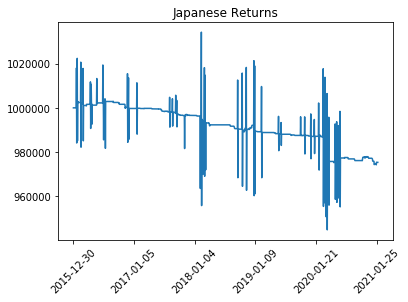

Opening positions:
We bought 657 shares of underlying stock (7751) at the price of 27.7 USD (Total: 18197.53, 3263.26 foreign dollars) on 2016-01-21
We sold 657 shares of ADR (CAJ) at the price of 27.92 (Total: 18344.79) on 2016-01-22
Opening positions:
We bought 1756 shares of underlying stock (7203) at the price of 56.01 USD (Total: 98349.3, 6598.59 foreign dollars) on 2016-01-21
We sold 878 shares of ADR (TM) at the price of 114.99 (Total: 100965.51) on 2016-01-22
Closing positions:
We sold 657 shares of underlying stock (7751) at the price of 28.07 USD (Total: 49283.03331.66 foreign dollars) on 2016-01-22
We bought 657 shares of ADR (CAJ) at the price of 27.92 (Total: 18342.05) on 2016-01-25
Closing positions:
We sold 1756 shares of underlying stock (7203) at the price of 57.87 USD (Total: 101626.06870.12 foreign dollars) on 2016-01-22



In [98]:
plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))

In [87]:
print(list(zip(dates, portfolio_values))[:20])

[('2015-12-30', 1000000.0), ('2016-01-04', 1000000.0), ('2016-01-05', 1000000.0), ('2016-01-06', 1000000.0), ('2016-01-07', 1000000.0), ('2016-01-08', 1000000.0), ('2016-01-12', 1000000.0), ('2016-01-13', 1000000.0), ('2016-01-14', 1000000.0), ('2016-01-15', 1000000.0), ('2016-01-19', 1000000.0), ('2016-01-20', 1000000.0), ('2016-01-21', 1017993.7577477419), ('2016-01-22', 984126.1119282733), ('2016-01-25', 1003922.6711682733), ('2016-01-26', 1022329.1178881059), ('2016-01-27', 985130.9559873482), ('2016-01-28', 1002808.6959873482), ('2016-01-29', 1002745.2180209765), ('2016-02-01', 1002363.9266405469)]


# Global Variant 2

In [18]:
df_dict = {}
for (country, adr) in list_pairs:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    ind_hp_dict = {}
    # Should be read in from file
    ind_hp_dict["lookback"] = 100
    ind_hp_dict["entry"] = 1
    ind_hp_dict["exit"] = 1
    ind_hp_dict["stop_loss"] = 3
    ind_hp_dict["allocation"] = 1/len(list_pairs)
    hp_dict[(country, adr)] = ind_hp_dict
    
diff_record_bid_dict = {}
diff_record_ask_dict = {}
for (country, adr) in list_pairs:
    diff_record_bid_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_ask_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    #iter_dict[(country, adr)]["has_current_date"] = False
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 1000000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [19]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                # Add stock values
                prev_value += positions[(country, adr)]["stock_pos"]*(row['stock_open']/row['avg_ask_non_us_at'])
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record_bid = diff_record_bid_dict[(country, adr)]
                    diff_record_ask = diff_record_ask_dict[(country, adr)]
                    diff_record_bid.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_bid_us_before'])
                    diff_record_ask.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_ask_us_before'])
                    
                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    if len(diff_record_bid) < lookback or row["date"] < start_date or row["date"] > end_date:
                        continue

                    ask_mean = np.array(diff_record_ask).mean()
                    bid_std = np.array(diff_record_bid).std()
                    ask_std = np.array(diff_record_ask).std()

                    entry = hp_dict[(country, adr)]["entry"]
                    exit = hp_dict[(country, adr)]["exit"]
                    stop_loss = hp_dict[(country, adr)]["stop_loss"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]

                    if diff_record_bid[-1] > ask_mean + entry*bid_std and diff_record_bid[-1] <= ask_mean + stop_loss*bid_std:
                        if stock_pos == 0 and adr_pos == 0:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    continue
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                                
                            adr_pos -= adr_quantity
                            positions[(country, adr)]["adr_pos"] -= adr_quantity
                            adr_px = row['adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            stock_pos += stock_quantity
                            positions[(country, adr)]["stock_pos"] += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash -= stock_px*stock_quantity

                            positions[(country, adr)]["holding_period"] = 0
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            
                    # Liquidation condition
                    elif (diff_record_ask[-1] < ask_mean + exit*ask_std or 
                          diff_record_bid[-1] > ask_mean + stop_loss*bid_std or 
                          holding_period == maximum_holding_period):
                        if stock_pos > 0 and adr_pos < 0 : 
                            adr_px = row['adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                            cash += stock_pos*stock_px

                            
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            
                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None

                #iter_dict[(country, adr)]["has_current_date"] = False

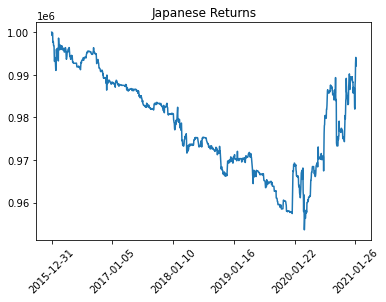

Opening positions:
We sold 311 shares of ADR (WBK) at the price of 23.43654 on 2016-01-04
We bought 311 shares of underlying stock (WBC) at the price of 23.523662324324324 USD (32.70267 foreign dollars) on 2016-01-04
Opening positions:
We sold 80 shares of ADR (ACH) at the price of 7.8621300000000005 on 2016-01-04
We bought 2000 shares of underlying stock (2600) at the price of 0.31673045451031384 USD (2.45245 foreign dollars) on 2016-01-04
Opening positions:
We sold 29 shares of ADR (CEA) at the price of 26.293680000000002 on 2016-01-04
We bought 1450 shares of underlying stock (670) at the price of 0.5390881613502077 USD (4.174169999999999 foreign dollars) on 2016-01-04
Opening positions:
We sold 610 shares of ADR (LFC) at the price of 15.25473 on 2016-01-04



In [20]:
plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))

# Global Variant 3(a)

In [8]:
df_dict = {}
for (country, adr) in list_pairs:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    ind_hp_dict = {}
    # Should be read in from file
    ind_hp_dict["lookback"] = 100
    ind_hp_dict["entry_cond1_val"] = 1
    ind_hp_dict["entry_cond2_val"] = 1
    ind_hp_dict["exit_cond1_val"] = 0
    ind_hp_dict["exit_cond2_val"] = 0
    ind_hp_dict["stop_loss_cond1"] = 3
    ind_hp_dict["stop_loss_cond2"] = 3
    ind_hp_dict["allocation"] = 1/len(list_pairs)
    hp_dict[(country, adr)] = ind_hp_dict
    
diff_record_bid_cond1_dict = {}
diff_record_ask_cond1_dict = {}
diff_record_bid_cond2_dict = {}
diff_record_ask_cond2_dict = {}
for (country, adr) in list_pairs:
    diff_record_bid_cond1_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_ask_cond1_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_bid_cond2_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_ask_cond2_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    positions[(country, adr)]["trade_type"] = None
    
conditions = {}
for (country, adr) in list_pairs:
    conditions[(country, adr)] = {}
    conditions[(country, adr)]["enter_cond1"] = False
    conditions[(country, adr)]["exit_cond1"] = False
    conditions[(country, adr)]["enter_cond2"] = False
    conditions[(country, adr)]["exit_cond2"] = False
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 1000000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [9]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = prev_cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                # Add stock values
                prev_value += positions[(country, adr)]["stock_pos"]*(row['stock_open']/row['avg_ask_non_us_at'])
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
        prev_cash = cash
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record_bid_cond1 = diff_record_bid_cond1_dict[(country, adr)]
                    diff_record_ask_cond1 = diff_record_ask_cond1_dict[(country, adr)]
                    diff_record_bid_cond2 = diff_record_bid_cond2_dict[(country, adr)]
                    diff_record_ask_cond2 = diff_record_ask_cond2_dict[(country, adr)]
                    diff_record_bid_cond1.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_bid_us_before'])
                    diff_record_ask_cond1.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_ask_us_before'])
                    diff_record_bid_cond2.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
                    diff_record_ask_cond2.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])

                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    
                    # row["date"] is between start_date (inclusive) and end_date (inclusive)
                    if len(diff_record_bid_cond1) < lookback or row["date"] < start_date or row["date"] > end_date:
                        continue

                    ask_mean_cond1 = np.array(diff_record_ask_cond1).mean()
                    bid_std_cond1 = np.array(diff_record_bid_cond1).std()
                    ask_std_cond1 = np.array(diff_record_ask_cond1).std()
                    ask_mean_cond2 = np.array(diff_record_ask_cond2).mean()
                    bid_std_cond2 = np.array(diff_record_bid_cond2).std()
                    ask_std_cond2 = np.array(diff_record_ask_cond2).std()

                    entry_cond1_val = hp_dict[(country, adr)]["entry_cond1_val"]
                    entry_cond2_val = hp_dict[(country, adr)]["entry_cond2_val"]
                    exit_cond1_val = hp_dict[(country, adr)]["exit_cond1_val"]
                    exit_cond2_val = hp_dict[(country, adr)]["exit_cond2_val"]
                    stop_loss_cond1 = hp_dict[(country, adr)]["stop_loss_cond1"]
                    stop_loss_cond2 = hp_dict[(country, adr)]["stop_loss_cond2"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    trade_type = positions[(country, adr)]["trade_type"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]
                    
                    enter_cond1 = conditions[(country, adr)]["enter_cond1"]
                    exit_cond1 = conditions[(country, adr)]["exit_cond1"]
                    enter_cond2 = conditions[(country, adr)]["enter_cond2"]
                    exit_cond2 = conditions[(country, adr)]["exit_cond2"]
                    
                    if not (enter_cond2 or exit_cond2):
                        enter_cond1 = (diff_record_bid_cond1[-1] > ask_mean_cond1 + entry_cond1_val*bid_std_cond1 
                                       and diff_record_bid_cond1[-1] <= ask_mean_cond1 + stop_loss_cond1*bid_std_cond1
                                       and stock_pos == 0 and adr_pos == 0)
                        exit_cond1 = ((diff_record_ask_cond1[-1] < ask_mean_cond1 + exit_cond1_val*ask_std_cond1 
                                      or diff_record_bid_cond1[-1] > ask_mean_cond1 + stop_loss_cond1*bid_std_cond1
                                      or (holding_period == maximum_holding_period and trade_type == 1))
                                      and stock_pos > 0 and adr_pos < 0)
                        
                        if enter_cond1:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    enter_cond1 = False
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                            if units != 0:
                                
                                adr_pos -= adr_quantity
                                positions[(country, adr)]["adr_pos"] -= adr_quantity
                                adr_px = row['adr_open']*short_multiplier
                                cash += adr_quantity*adr_px

                                stock_pos += stock_quantity
                                positions[(country, adr)]["stock_pos"] += stock_quantity
                                stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                                cash -= stock_px*stock_quantity
                                
                                prev_cash = cash
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                positions[(country, adr)]["holding_period"] = 0
                                positions[(country, adr)]["trade_type"] = 1
                                
                                trade_records.append("Opening positions:\n")
                                # Times in EST
                                trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")

                        elif exit_cond1:
                            adr_px = row['adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                            cash += stock_pos*stock_px

                            
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            
                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None
                            positions[(country, adr)]["trade_type"] = None
                            
                            prev_cash = cash
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                            
                        conditions[(country, adr)]["enter_cond1"] = enter_cond1
                        conditions[(country, adr)]["exit_cond1"] = exit_cond1
                            
                    if not (enter_cond1 or exit_cond1) and merged_df.loc[index+1, "date"] <= end_date:
                        
                        # Check and possibly trade condition 2
                        enter_cond2 = (diff_record_bid_cond2[-1] > ask_mean_cond2 + entry_cond2_val*bid_std_cond2 
                               and diff_record_bid_cond2[-1] <= ask_mean_cond2 + stop_loss_cond2*bid_std_cond2
                               and stock_pos == 0 and adr_pos == 0)
                        exit_cond2 = ((diff_record_ask_cond2[-1] < ask_mean_cond2 + exit_cond2_val*ask_std_cond2 
                              or diff_record_bid_cond2[-1] > ask_mean_cond2 + stop_loss_cond2*bid_std_cond2
                              or (holding_period == maximum_holding_period and trade_type == 2))
                              and stock_pos > 0 and adr_pos < 0)
                        
                        if enter_cond2:

                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    enter_cond2 = False
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                            if units != 0:
                                stock_pos += stock_quantity
                                positions[(country, adr)]["stock_pos"] += stock_quantity
                                stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                                cash -= stock_px*stock_quantity
                                # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                                prev_cash = cash
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                adr_pos -= adr_quantity
                                positions[(country, adr)]["adr_pos"] -= adr_quantity
                                adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                                cash += adr_quantity*adr_px

                                positions[(country, adr)]["holding_period"] = 0
                                positions[(country, adr)]["trade_type"] = 2
                                trade_records.append("Opening positions:\n")
                                # Times in EST
                                trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                                trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                        # Liquidation condition
                        elif exit_cond2:
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                            cash += stock_pos*stock_px
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                            prev_cash = cash
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None
                            positions[(country, adr)]["trade_type"] = None
                            
                        conditions[(country, adr)]["enter_cond2"] = enter_cond2
                        conditions[(country, adr)]["exit_cond2"] = exit_cond2

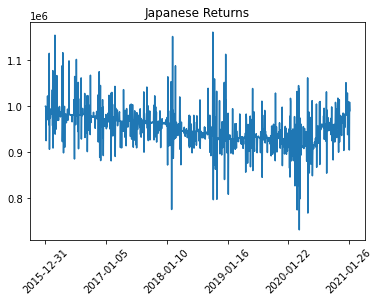

Opening positions:
We sold 311 shares of ADR (WBK) at the price of 23.43654 on 2016-01-04
We bought 311 shares of underlying stock (WBC) at the price of 23.523662324324324 USD (32.70267 foreign dollars) on 2016-01-04
Opening positions:
We sold 80 shares of ADR (ACH) at the price of 7.8621300000000005 on 2016-01-04
We bought 2000 shares of underlying stock (2600) at the price of 0.31673045451031384 USD (2.45245 foreign dollars) on 2016-01-04
Opening positions:
We sold 29 shares of ADR (CEA) at the price of 26.293680000000002 on 2016-01-04
We bought 1450 shares of underlying stock (670) at the price of 0.5390881613502077 USD (4.174169999999999 foreign dollars) on 2016-01-04
Opening positions:
We sold 610 shares of ADR (LFC) at the price of 15.25473 on 2016-01-04



In [10]:
plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))

# Global Variant 3(b)

In [21]:
df_dict = {}
for (country, adr) in list_pairs:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    ind_hp_dict = {}
    # Should be read in from file
    ind_hp_dict["lookback"] = 100
    ind_hp_dict["entry_cond1_val"] = 1
    ind_hp_dict["entry_cond2_val"] = 1
    ind_hp_dict["exit_cond1_val"] = 0
    ind_hp_dict["exit_cond2_val"] = 0
    ind_hp_dict["stop_loss_cond1"] = 3
    ind_hp_dict["stop_loss_cond2"] = 3
    ind_hp_dict["allocation"] = 1/len(list_pairs)
    hp_dict[(country, adr)] = ind_hp_dict
    
diff_record_bid_dict = {}
diff_record_ask_dict = {}
for (country, adr) in list_pairs:
    diff_record_bid_dict[(country, adr)] = deque(maxlen = 2*hp_dict[(country, adr)]["lookback"])
    diff_record_ask_dict[(country, adr)] = deque(maxlen = 2*hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    positions[(country, adr)]["trade_type"] = None
    
conditions = {}
for (country, adr) in list_pairs:
    conditions[(country, adr)] = {}
    conditions[(country, adr)]["enter_cond1"] = False
    conditions[(country, adr)]["exit_cond1"] = False
    conditions[(country, adr)]["enter_cond2"] = False
    conditions[(country, adr)]["exit_cond2"] = False
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 1000000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [22]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = prev_cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                # Add stock values
                prev_value += positions[(country, adr)]["stock_pos"]*(row['stock_open']/row['avg_ask_non_us_at'])
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
        prev_cash = cash
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record_bid = diff_record_bid_dict[(country, adr)]
                    diff_record_ask = diff_record_ask_dict[(country, adr)]
                    diff_record_bid.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_bid_us_before'])
                    diff_record_ask.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_ask_us_before'])
                    lookback = 2*hp_dict[(country, adr)]["lookback"]
                    if len(diff_record_bid) == lookback and row["date"] >= start_date and row["date"] <= end_date:
                        ask_mean = np.array(diff_record_ask).mean()
                        bid_std = np.array(diff_record_bid).std()
                        ask_std = np.array(diff_record_ask).std()
                        
                        entry_cond1_val = hp_dict[(country, adr)]["entry_cond1_val"]
                        entry_cond2_val = hp_dict[(country, adr)]["entry_cond2_val"]
                        exit_cond1_val = hp_dict[(country, adr)]["exit_cond1_val"]
                        exit_cond2_val = hp_dict[(country, adr)]["exit_cond2_val"]
                        stop_loss_cond1 = hp_dict[(country, adr)]["stop_loss_cond1"]
                        stop_loss_cond2 = hp_dict[(country, adr)]["stop_loss_cond2"]
                        stock_pos = positions[(country, adr)]["stock_pos"]
                        adr_pos = positions[(country, adr)]["adr_pos"]
                        holding_period = positions[(country, adr)]["holding_period"]
                        trade_type = positions[(country, adr)]["trade_type"]
                        stock_name = adr.split("_")[1]
                        adr_name = adr.split("_")[0]

                        enter_cond1 = conditions[(country, adr)]["enter_cond1"]
                        exit_cond1 = conditions[(country, adr)]["exit_cond1"]
                        enter_cond2 = conditions[(country, adr)]["enter_cond2"]
                        exit_cond2 = conditions[(country, adr)]["exit_cond2"]
                    
                        if not (enter_cond2 or exit_cond2):
                            enter_cond1 = (diff_record_bid[-1] > ask_mean + entry_cond1_val*bid_std
                                   and diff_record_bid[-1] <= ask_mean + stop_loss_cond1*bid_std
                                   and stock_pos == 0 and adr_pos == 0)
                            exit_cond1 = ((diff_record_ask[-1] < ask_mean + exit_cond1_val*ask_std
                                          or diff_record_bid[-1] > ask_mean + stop_loss_cond1*bid_std
                                          or (holding_period == maximum_holding_period and trade_type == 1))
                                          and stock_pos > 0 and adr_pos < 0)

                            if enter_cond1:
                                portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                                stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                                units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                                (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_us_before']), 
                                                adr_volume, 
                                                stock_volume))
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])

                                # Take portfolio value for each previous day when the Asian market opens
                                temp_risk_lookback = min(risk_lookback, index)
                                stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                                adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                                sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                if (var > portfolio_value_before_entering*var_limit or 
                                    max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                    sigma > portfolio_value_before_entering*sigma_limit):
                                    frac = min((portfolio_value_before_entering*var_limit)/var, 
                                               (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                              (portfolio_value_before_entering*sigma_limit)/sigma)
                                    units = int(frac*units)
                                    if units == 0:
                                        enter_cond1 = False
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])   
                                if units != 0:

                                    adr_pos -= adr_quantity
                                    positions[(country, adr)]["adr_pos"] -= adr_quantity
                                    adr_px = row['adr_open']*short_multiplier
                                    cash += adr_quantity*adr_px

                                    stock_pos += stock_quantity
                                    positions[(country, adr)]["stock_pos"] += stock_quantity
                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                    stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                                    cash -= stock_px*stock_quantity

                                    prev_cash = cash
                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                    positions[(country, adr)]["holding_period"] = 0
                                    positions[(country, adr)]["trade_type"] = 1

                                    trade_records.append("Opening positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")

                            elif exit_cond1:
                                adr_px = row['adr_open']*long_multiplier
                                cash -= abs(adr_pos)*adr_px

                                stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                                cash += stock_pos*stock_px


                                trade_records.append("Closing positions:\n")
                                # Times in EST
                                trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")

                                positions[(country, adr)]["stock_pos"] = 0
                                positions[(country, adr)]["adr_pos"] = 0
                                positions[(country, adr)]["holding_period"] = None
                                positions[(country, adr)]["trade_type"] = None

                                prev_cash = cash
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            conditions[(country, adr)]["enter_cond1"] = enter_cond1
                            conditions[(country, adr)]["exit_cond1"] = exit_cond1
                            
                    diff_record_bid.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
                    diff_record_ask.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])
                    if len(diff_record_bid) == lookback and row["date"] >= start_date and merged_df.loc[index+1,"date"] <= end_date:
                        ask_mean = np.array(diff_record_ask).mean()
                        bid_std = np.array(diff_record_bid).std()
                        ask_std = np.array(diff_record_ask).std()
                        
                        if not (enter_cond1 or exit_cond1):

                            # Check and possibly trade condition 2
                            enter_cond2 = (diff_record_bid[-1] > ask_mean + entry_cond2_val*bid_std
                                   and diff_record_bid[-1] <= ask_mean + stop_loss_cond2*bid_std
                                   and stock_pos == 0 and adr_pos == 0)
                            exit_cond2 = ((diff_record_ask[-1] < ask_mean + exit_cond2_val*ask_std
                                          or diff_record_bid[-1] > ask_mean + stop_loss_cond2*bid_std
                                          or (holding_period == maximum_holding_period and trade_type == 2))
                                          and stock_pos > 0 and adr_pos < 0)

                            if enter_cond2:

                                portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                                stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                                units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                                (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                                adr_volume, 
                                                stock_volume))
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])

                                # Take portfolio value for each previous day when the Asian market opens
                                temp_risk_lookback = min(risk_lookback, index)
                                stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                                adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                                sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                if (var > portfolio_value_before_entering*var_limit or 
                                    max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                    sigma > portfolio_value_before_entering*sigma_limit):
                                    frac = min((portfolio_value_before_entering*var_limit)/var, 
                                               (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                              (portfolio_value_before_entering*sigma_limit)/sigma)
                                    units = int(frac*units)
                                    if units == 0:
                                        enter_cond2 = False
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])   
                                if units != 0:
                                    stock_pos += stock_quantity
                                    positions[(country, adr)]["stock_pos"] += stock_quantity
                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                    stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                                    cash -= stock_px*stock_quantity
                                    # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                                    prev_cash = cash
                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                    adr_pos -= adr_quantity
                                    positions[(country, adr)]["adr_pos"] -= adr_quantity
                                    adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                                    cash += adr_quantity*adr_px

                                    positions[(country, adr)]["holding_period"] = 0
                                    positions[(country, adr)]["trade_type"] = 2
                                    trade_records.append("Opening positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                                    trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                            # Liquidation condition
                            elif exit_cond2:
                                stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                                cash += stock_pos*stock_px
                                # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                                prev_cash = cash
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                                cash -= abs(adr_pos)*adr_px
                                trade_records.append("Closing positions:\n")
                                # Times in EST
                                trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                                trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                                positions[(country, adr)]["stock_pos"] = 0
                                positions[(country, adr)]["adr_pos"] = 0
                                positions[(country, adr)]["holding_period"] = None
                                positions[(country, adr)]["trade_type"] = None

                            conditions[(country, adr)]["enter_cond2"] = enter_cond2
                            conditions[(country, adr)]["exit_cond2"] = exit_cond2

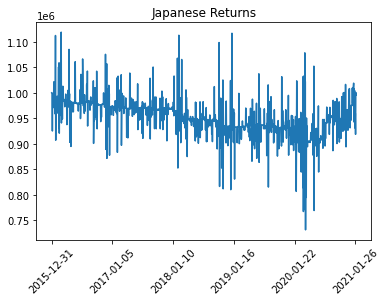

Opening positions:
We sold 311 shares of ADR (WBK) at the price of 23.43654 on 2016-01-04
We bought 311 shares of underlying stock (WBC) at the price of 23.523662324324324 USD (32.70267 foreign dollars) on 2016-01-04
Opening positions:
We sold 80 shares of ADR (ACH) at the price of 7.8621300000000005 on 2016-01-04
We bought 2000 shares of underlying stock (2600) at the price of 0.31673045451031384 USD (2.45245 foreign dollars) on 2016-01-04
Opening positions:
We sold 29 shares of ADR (CEA) at the price of 26.293680000000002 on 2016-01-04
We bought 1450 shares of underlying stock (670) at the price of 0.5390881613502077 USD (4.174169999999999 foreign dollars) on 2016-01-04
Opening positions:
We sold 610 shares of ADR (LFC) at the price of 15.25473 on 2016-01-04



In [23]:
plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))